In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib 
import matplotlib as mpl
import tensorflow as tf
from ExoRIM.definitions import *
import gc

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
def mas2rad(x):
    ''' Convenient little function to convert milliarcsec to radians '''
    return x*np.pi/(180*3600*1000)

def rad2mas(x):
    ''' Convenient little function to convert radians to milliarcseconds '''
    return x/np.pi*(180*3600*1000)

#[AL: 2014.05.15] Normalization was fixed
def cvis_binary(u, v, wavel, p, norm=False):
    ''' Calc. complex vis measured by an array for a binary star
    ----------------------------------------------------------------
    p: 3-component vector (+2 optional), the binary "parameters":
    - p[0] = sep (mas)
    - p[1] = PA (deg) E of N.
    - p[2] = contrast ratio (primary/secondary)
    
    optional:
    - p[3] = angular size of primary (mas)
    - p[4] = angular size of secondary (mas)

    - u,v: baseline coordinates (meters)
    - wavel: wavelength (meters)

    - norm=None (required for vis2)
    ---------------------------------------------------------------- '''

    p = np.array(p)
    # relative locations
    th = (p[1] + 90.0) * np.pi / 180.0
    ddec =  mas2rad(p[0] * np.sin(th))
    dra  = -mas2rad(p[0] * np.cos(th))

    # baselines into number of wavelength
    x = np.sqrt(u*u + v*v) / wavel

    # decompose into two "luminosity"
    l2 = 1. / (p[2] + 1)
    l1 = 1 - l2
    
    # phase-factor
    phi = np.zeros(u.size, dtype=complex)
    phi.real = np.cos(-2*np.pi*(u*dra + v*ddec)/wavel)
    phi.imag = np.sin(-2*np.pi*(u*dra + v*ddec)/wavel)

    # optional effect of resolved individual sources
    if p.size == 5:
        th1, th2 = mas2rad(p[3]), mas2rad(p[4])
        v1 = 2*j1(np.pi*th1*x)/(np.pi*th1*x)
        v2 = 2*j1(np.pi*th2*x)/(np.pi*th2*x)
    else:
        v1 = np.ones(u.size)
        v2 = np.ones(u.size)

    cvis = l1 * v1 + l2 * v2 * phi
    if norm :
        cvis/=(l1+l2)                   
    return cvis


In [3]:
import pyfits as pf
from scipy.interpolate import RectBivariateSpline as interp 
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw

def palomarpupil(sz=128, spiders=True):
	'''------------------------------------------------
	simpupil.py 

	generates a Palomar pupil

	Owes a lot to Anthony Cheetham's IDL script
	------------------------------------------------'''

	#things to edit
	rmax   = 2.3918*1.00 # from optimization #5.093/2.  * 15.4/16.88        # outer diameter:      5.093 m
	rmin   = rmax/2.11885 # 1.829/2. * 7.6/6.08         # central obstruction: 1.829 m
	thick  = 0.2292*(rmax-rmin)*0.96 # 0.83 *15.4/16.88/4.         # adopted spider thickness (meters)

	'''-------------------------------------------
	Initialise your arrays
	-------------------------------------------'''

	mask = np.ones((sz,sz))

	# get coordinates for the full un-cropped image
	xs, ys = np.linspace(-sz/2,sz/2,sz), np.linspace(-sz/2,sz/2,sz)
	xs *= 11*rmax/xs.max()
	ys *= 11*rmax/ys.max()

	xx,yy = np.meshgrid(xs,ys)
	rr = np.sqrt(xx**2 + yy**2)

	m2pix = sz/(xx.max()-xx.min())
	pix2m = 1./m2pix

	'''-------------------------------------------
	Put in the primary and secondary sizes
	-------------------------------------------'''

	mask /= mask.max()
	mask[rr>rmax] = 0
	mask[rr<rmin] = 0

	'''-------------------------------------------
	Now do the spiders
	-------------------------------------------'''
	if spiders:
		angles = [0., 90., 180., 270.]

		img = Image.fromarray(mask)
		draw = ImageDraw.Draw(img)

		for j, angle in enumerate(angles):
			
			angle *= np.pi/180.

			start = 1.1*rmax*np.array([np.cos(angle),np.sin(angle)])-xx.min()
			stop = np.array([0,0])-xx.min()

			normvec = np.array([start[1] - stop[1], stop[0] - start[0]]) * thick
			corners = np.round(m2pix * np.array([start + normvec,
                                                 start - normvec,
                                                 stop - normvec,
                                                 stop + normvec]))

			#convert to pixels

			draw.polygon([tuple(p) for p in corners], fill=0)

		img = np.copy(mask)
		img[np.abs(xx)<=thick/2.] = 0
		img[np.abs(yy)<=thick/2.] = 0

		newmask = np.copy(np.asarray(img))
	else:
		newmask = np.copy(mask)


	'''-------------------------------------------
	Display
	-------------------------------------------'''

# 	plt.figure(0)
# 	plt.imshow(newmask,cmap=plt.cm.gray,extent=[xx.min(),xx.max(),xx.min(),xx.max()])
# 	plt.xlabel('x (m)')
# 	plt.ylabel('y (m)')
# 	plt.title('WFIRST Pupil')
# 	plt.draw()
# 	plt.show()

	return newmask,xs,m2pix

palomarpupil()

/home/aadam/anaconda3/envs/Base3.6/lib/python3.6/site-packages/pyfits-3.5-py3.6-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-26.3098    , -25.89547244, -25.48114488, -25.06681732,
        -24.65248976, -24.2381622 , -23.82383465, -23.40950709,
        -22.99517953, -22.58085197, -22.16652441, -21.75219685,
        -21.33786929, -20.92354173, -20.50921417, -20.09488661,
        -19.68055906, -19.2662315 , -18.85190394, -18.43757638,
        -18.02324882, -17.60892126, -17.1945937 , -16.78026614,
        -16.36593858, -15.95161102, -15.53728346, -15.12295591,
        -14.70862835, -14.29430079, -13.87997323, -13.46564567,
        -13.05131811, -12.63699055, -12.22266299, -11.80833543,
        -11.39400787, -10.97968031, -10.56535276, -10.1510252 ,
         -9.73669764,  -9.32237008,  -8.90804252,  -8.49371496,
         -8.0793874 ,  -7.66505984,  -7.2507322

In [17]:
# from pysco diffract tools, under GNU license
shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

def shift_image(img,x=0,y=0,doRoll=True) :
	# step 1 - shifting to the value less than zero
	# flipping image to work with positive shifts only
	in_img=img
	if x<0 :
		in_img=np.fliplr(in_img)
	if y<0 :
		in_img=np.flipud(in_img)
	x_abs=np.abs(x)
	y_abs=np.abs(y)
	float_x=x_abs-int(x_abs)
	float_y=y_abs-int(y_abs)
	if float_x>0 or float_y>0 :
		res=(1-float_x)*(1-float_y)*in_img
		img12=float_x*(1-float_y)*in_img
		img21=(1-float_x)*float_y*in_img
		img22=float_x*float_y*in_img
		res[1:res.shape[0],0:res.shape[1]]+=img12[0:res.shape[0]-1,0:res.shape[1]]
		res[0:res.shape[0],1:res.shape[1]]+=img21[0:res.shape[0],0:res.shape[1]-1]
		res[1:res.shape[0],1:res.shape[1]]+=img22[0:res.shape[0]-1,0:res.shape[1]-1]
		if doRoll :
			res[0,:]+=img12[res.shape[0]-1,:]
			res[:,0]+=img21[:,res.shape[1]-1]
			res[0,0]+=img22[res.shape[0]-1,res.shape[1]-1]
	else :
		res=in_img
	#step2 - shifting to discrete number of pixels
	if not doRoll :
		if x_abs<res.shape[0] and y_abs<res.shape[1] :
			shifted=res[0:res.shape[0]-int(x_abs),0:res.shape[1]-int(y_abs)]
			res=np.zeros(np.shape(res))
			res[int(x_abs):res.shape[0],int(y_abs):res.shape[1]]=shifted	
		else :
			res=np.zeros(np.shape(res))
	else :
		res=np.roll(res,int(x_abs),axis=0)
		res=np.roll(res,int(y_abs),axis=1)
	# flipping back
	if x<0 :
		res=np.fliplr(res)
	if y<0 :
		res=np.flipud(res)
	return res

def shift_image_ft(image,shift):
	"""Shift an image by fractional pixels using an FFT
	(why isn't this in scipy?)"""

	calim_ft = np.fft.rfft2(image[:,:])
	x = np.arange(calim_ft.shape[1],dtype=np.double)
	y = ((np.arange(calim_ft.shape[0]) + calim_ft.shape[0]/2.0) % calim_ft.shape[0]) - calim_ft.shape[0]/2.0
	x *= 2*np.pi/calim_ft.shape[0]
	y *= 2*np.pi/calim_ft.shape[0]
	xy = np.meshgrid(x,y)

	return subpix_fftshift(calim_ft,xy,shift)

def subpix_fftshift(ftim,xy,shift):
	"""Shift an image by fractional pixels using an FFT
	(why isn't this in scipy?)"""

	return np.fft.irfft2(ftim*np.exp(1j*(xy[0]*shift[0] + xy[1]*shift[1])))



def make_binary(sep,theta,contrast,spaxel=25.2,wavel=2.145e-6,sz=4096,tel='palomar'):

	psf, xx = diffract(wavel=wavel,spaxel=spaxel,sz=sz,tel=tel)

	x,y = np.cos(theta*np.pi/180)*sep/spaxel, np.sin(theta*np.pi/180)*sep/spaxel

	print('x',x,',y',y)
		
	companion = shift_image_ft(psf,[-y,-x])/contrast

	binary_image = psf + companion - companion.min()#shift_image(psf,x=x,y=y,doRoll=True)/contrast

	return binary_image/binary_image.max(), xx

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


def frebin(array, shape, total=True):
    '''Function that performs flux-conservative
    rebinning of an array.

    Inputs:
        array: numpy array to be rebinned
        shape: tuple (x,y) of new array size
	total: Boolean, when True flux is conserved

    Outputs:
	new_array: new rebinned array with dimensions: shape
    '''

    #Determine size of input image
    y, x = array.shape

    y1 = y-1
    x1 = x-1

    xbox = x/float(shape[0])
    ybox = y/float(shape[1])

    #Determine if integral contraction so we can use rebin
    if (x == int(x)) and (y == int(y)):
        if (x % shape[0] == 0) and (y % shape[1] == 0):
            return rebin(array, (shape[1], shape[0]))*xbox*ybox

    #Otherwise if not integral contraction
    #First bin in y dimension
    temp = np.zeros((shape[1], x),dtype=float)
    #Loop on output image lines
    for i in range(0, int(shape[1]), 1):
        rstart = i*ybox
        istart = int(rstart)
        rstop = rstart + ybox
        istop = int(rstop)
        if istop > y1:
            istop = y1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
        
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            temp[i,:] = (1.0 - frac1 - frac2)*array[istart,:]
        else:
            temp[i,:] = np.sum(array[istart:istop+1,:], axis=0)\
                        - frac1*array[istart,:]\
                        - frac2*array[istop,:]
            
    temp = np.transpose(temp)

    #Bin in x dimension
    result = np.zeros((shape[0], shape[1]), dtype=float)
    #Loop on output image samples
    for i in range(0, int(shape[0]), 1):
        rstart = i*xbox
        istart = int(rstart)
        rstop = rstart + xbox
        istop = int(rstop)
        if istop > x1:
            istop = x1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
    #Add pixel values from istart to istop an subtract
    #fracion pixel from istart to rstart and fraction
    #fraction pixel from rstop to istop.
        if istart == istop:
            result[i,:] = (1.-frac1-frac2)*temp[istart,:]
        else:
            result[i,:] = np.sum(temp[istart:istop+1,:], axis=0)\
                          - frac1*temp[istart,:]\
                          - frac2*temp[istop,:]

    if total:
        return np.transpose(result)
    elif not total:
        return np.transpose(result)/float(xbox*ybox)

def spaxel_scale(image, pscale, spaxel, verbose=False):
    '''Function that takes image and rebins it to chosen
    spaxel scale. Reads spaxel scale of input image
    from header keywords CDELT1/2 - UNITS MUST BE 'MAS'. 

    Inputs:
        image: science image FITS file
        spaxel: spaxel scale mas (x, y)
        new_file: new FITS filename and path

    Outputs:
        new_cube: datacube rebinned to chosen spaxel scale
        new_head: updated header file

    This is Ben's hack to get it to take ordinary arrays
    '''

    #print 'Spaxel scale'

    y, x = image.shape
    cdelt1 = pscale #hacky hack hack
    cdelt2 = pscale

    #total field of view in mas
    x_field = cdelt1*x
    y_field = cdelt2*y

    x_newsize = int(x_field/float(spaxel))
    y_newsize = int(y_field/float(spaxel))

    new_im = np.zeros((y_newsize, x_newsize))

    # print (x_newsize, y_newsize)

    new_im[:,:] = frebin(image, (x_newsize, y_newsize), total=True)

    if verbose:
        print('Spaxel scale - done!')

    # p.writeto(str(new_file), new_im, head) 
    
    return new_im

# =========================================================================
# =========================================================================

def diffract(wavel=2.145e-6, spaxel=25.2, seeingfile=None, sz=128, tel='palomar', phases=True):
    '''Run a diffraction simulation!'''

    # wavel = params[0]
    # rprim = params[1]
    # rsec = params[2]
    # stop = params[3] #stop size in lambda/D
    # spaxel = params[4]

    '''----------------------------------------
    Calculate an input pupil.
    ----------------------------------------'''

    if tel == 'palomar':
        pupil,xs,m2pix = palomarpupil(sz=sz)#np.ones((sz,sz),dtype='complex')+0j
        rprim = 5.093/2.  * 15.4/16.88 		
    elif tel == 'wfirst':
        pupil,xs,m2pix = wfirstpupil(sz=sz)#np.ones((sz,sz),dtype='complex')+0j
        rprim = 2.4
    elif tel == 'jwst':
        pupil,xs,m2pix = jwstpupil(sz=sz)
        rprim = 6.5/2.
    elif tel == 'wfc3':
        pupil,xs,m2pix = wfc3pupil(sz=sz)
        rprim = 1.2
    else: 
        print('Telescope must be palomar, wfirst or jwst')

    reso = rad2mas(wavel/(2*rprim))

    print('Lambda/D =',reso,'mas')

    pupil = pupil + 0j

    # get coordinates for the full un-cropped image
    # xs, ys = np.linspace(-sz/2,sz/2,sz), np.linspace(-sz/2,sz/2,sz)
    # xs *= 3*rprim/xs.max()
    # ys *= 3*rprim/ys.max()
    ys = xs

    xx,yy = np.meshgrid(xs,ys)
    rr = np.sqrt(xx**2 + yy**2)

    # m2pix = sz/(xx.max()-xx.min())
    pix2m = 1./m2pix

    freqs = shift(fftfreq(sz,d=pix2m))

    '''----------------------------------------
    Apply a phase screen.
    ----------------------------------------'''
    if phases:
        if tel == 'jwst':
            phases = jwstphases 
            pscreen = phase_jwst(pupil,xs,phases)
            pscreen = np.exp(1.j*(pscreen))
            pupil[pupil>=0.01] = 1.+0j # normalise
            pupil *= pscreen

        else:
            interpfun = screen(seeingfile)

            seeing = interpfun(xs+xs.min(),ys+ys.min())

            seeing = np.exp(1.j*(seeing))

            pupil *= seeing 

        pupil[np.abs(pupil.real)<=0.01] = 0+0j

            # display image
        plt.figure(0)
        plt.clf()
        plt.imshow(np.angle(pupil),extent=[xs.min(),xs.max(),xs.min(),xs.max()],
            interpolation='none',origin='lower')
        plt.xlabel('m')
        plt.ylabel('m')
        plt.title('Input Phase Screen')
        cbar = plt.colorbar()
        plt.draw()
        plt.show()

        rmsphase = np.sqrt(np.mean(np.angle(pupil[np.abs(pupil)>0]))**2)
        print('RMS Phase',rmsphase,'rad')

    # # where do you poke the phases?
    # angle = 45
    # dist = 0.5

    # angle *= np.pi/180.
    # poke = np.array([np.sin(angle),np.cos(angle)])
    # poke = poke*(rprim-rsec)*dist + poke*rsec

    # #phase piston a 1x1 m region cetred at the poke point
    # pupil[np.sqrt((xx-poke[0])**2 +(yy-poke[1])**2)<3] *= np.exp(0+1j)


    '''----------------------------------------
    Apply the pupil mask.
    ----------------------------------------'''

    # now limit the bandpass of the pupil

#     mask = np.ones(rr.shape,dtype='complex')
    #mask *= np.exp(-(rr-(rprim+rsec)/2.)**2/2./gausswidth**2)
    # mask /= mask.max()
#     mask[rr>rprim] = 0
#     mask[rr<rsec] = 0

#     pupil *= mask

    plt.figure(0)
    plt.clf()
    plt.imshow(np.abs(pupil),extent=[xx.min(),xx.max(),xx.min(),xx.max()],
        cmap=plt.cm.gray,interpolation='none')
    cbar = plt.colorbar()
    # plt.scatter(poke[0],poke[1],s=5)
    plt.xlim(xx.min(),xx.max())
    plt.ylim(xx.min(),xx.max())
    plt.xlabel('m')
    plt.ylabel('m')
    plt.title('Input Pupil')
    plt.show()

    # insert in a padded array

    # newpupil = np.zeros((sz*4,sz*4),dtype='complex')
    # newpupil[3*sz/2:5*sz/2,3*sz/2:5*sz/2] = pupil
    # pupil = newpupil

    '''----------------------------------------
    Propagate to the first focal plane.
    ----------------------------------------'''

    focal = shift(fft((pupil)))

    # get coordinates for the full un-cropped image
    focx = rad2mas(freqs*wavel)
    focxx,focyy = np.meshgrid(focx,focx)
    focrr = np.sqrt(focxx**2 + focyy**2)

    image = focal.real**2 + focal.imag**2

    imsz = image.shape[0]

    # 	display image
    plt.figure(1)
    plt.clf()
    plt.imshow(image**0.2,extent=[focx.min(),focx.max(),focx.min(),focx.max()],
        cmap=plt.cm.gray,interpolation='none')
    plt.xlabel('mas')
    plt.ylabel('mas')
    plt.title('Input PSF')
    cbar = plt.colorbar()
    plt.show()

    '''----------------------------------------
    Rebin
    ----------------------------------------'''

    pscale = (focx.max()-focx.min())/focx.size

    print('Native plate scale = ', pscale)
    # spaxel = 4. # mas

    # try:
    # 	rebin = fits_spaxel_scale(image2,pscale,spaxel,'config3.fits')
    # 	rebinx = focx/pscale*spaxel 
    # 	print 'saved!'
    # except:
    rebin = spaxel_scale(image,pscale,spaxel)
    rebinx = focx/pscale*spaxel
    try:
        rebin = rebin[rebin.shape[0]//2-256:rebin.shape[0]//2+256,
                      rebin.shape[1]//2-256:rebin.shape[1]//2+256]
    except:
        rebin = rebin[rebin.shape[0]//2-128:rebin.shape[0]//2+128,
                      rebin.shape[1]//2-128:rebin.shape[1]//2+128]
    plt.figure(1)
    plt.clf()
    plt.imshow(rebin*0.2,extent=[-pscale,pscale,-pscale,pscale],
        cmap=plt.cm.gray,interpolation='none')
    plt.xlabel('mas')
    plt.ylabel('mas')
    plt.title('Input PSF')
    cbar = plt.colorbar()
    plt.show()

    return rebin, rebinx


gc.collect()
image1, image2 = make_binary(100, 30, 300)

Lambda/D = 95.22050380675749 mas


NameError: name 'screen' is not defined

In [1]:
import gc
gc.collect()

168

In [13]:
bispectrum = kpi(file='coords.txt', bsp_mat='sparse')

File coords.txt isn't a valid Ker-phase data structure
Creating from coordinate file
15 distinct baselines were identified
10 Kernel Phases identified.
Now calculating bispectrum
Calculating bispectrum matrix. Will take a few minutes.
Done 0 of 6 .  10  bispectra found. Time taken: 0.0 sec
Done. Total time taken: 0.0 mins
Found 20 bispectra
Doing sparse svd
Matrix rank: 10
Reduced-rank bispectrum matrix calculated.
Matrix shape (10, 15)
Time taken: 0.0 mins


Text(0, 0.5, '$v$')

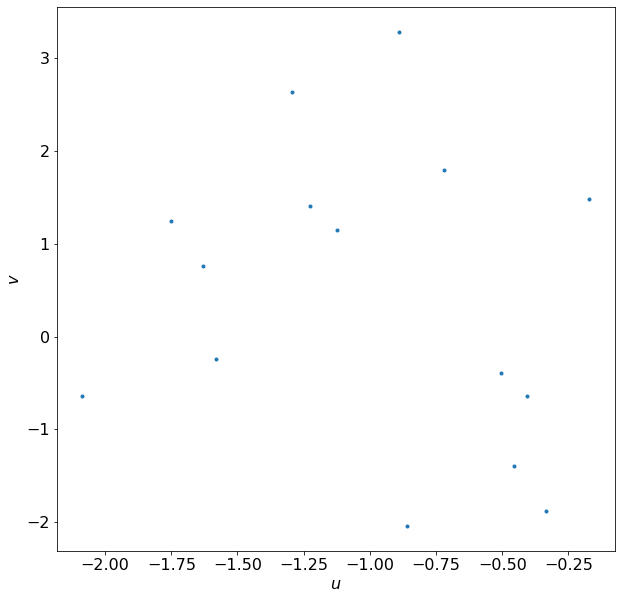

In [15]:
plt.plot(bispectrum.uv[:,0],bispectrum.uv[:,1],'.')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

In [16]:
## define your image grid

x = np.arange(128)
xx, yy = np.meshgrid(x,x)